# Фильтрация и анализ данных из подготовленной таблицы динамики признаков с использованием RNN LSTM
-------

**Дано:**
- имеется таблица, фиксирующая изменение всех важных признаков/фичей во времени (фичи генерировались и подбирались на предыдущем этапе);
- индексом таблицы является дата-время либо в виде TimeStamp либо в виде DateTime;
- все фичи закодированы численно либо как one-hot enc (категориальные фичи).

**Требуется:**
- разработать pipeline для эмбеддинга, кодирования окон изменения фичей с использованием AE или VAE;
- разработать функционал визуального анализа структуры кластеров кодов и соответствующих им окон;
- исследовать как архитектура сверточных слоев AE влияет на кодирование окон;
- выявить основные типы окон, которые может кодировать/распознавать/выделять АЭ в зависимости от его архитектуры.

In [ ]:
# подключаем колаб к нашему гугл-диску
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# устанавливаем рабочую директорию/каталог
import os

path = "/content/drive/My Drive/Colab Notebooks/Moneta/"
os.chdir(path)
# print(os.listdir())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import seaborn as sbn
np.set_printoptions(precision=3)

import datetime as dt
print('Last Updated On: ', dt.datetime.now().date())

import sys

""" параметры графиков """
plt.style.use('ggplot')
plt.rcParams['font.fantasy'] = 'Arial', 'Times New Roman', 'Tahoma', 'Comic Sans MS', 'Courier'

Last Updated On:  2023-01-31


# ПЛАН РАБОТ
---

1. Считываем и делаем визуальный анализ попарных зависимостей данных
1. Выбираем ширину окна. Формируем датасет и даталоадер для обучения и тестирования АЭ.
1. Строим АЭ с выделением энкодера и декодера в отдельную нейросеть
1. Обучаем АЭ
1. Кодируем энкодером окна
1. Кластеризуем окна; выбираем наилучший метод и параметры силуэтным анализом (k-means, )
1. Делаем проекцию tSNE и визуализируем кластерную структуру
1. Проводим анализ получившихся кластеров окон


## **Считываем данные**
---

Подготовленные данные 

datetime|	val_00 | val_01 | ...
--- | --- | --- | ---
01.01.2009|	29,3916 | -0.108 | ...
12.01.2009|	30,5331 | 1.1415 | ...




In [ ]:
prep_df = pd.read_csv('data/dollar_prepared.csv', header=0, sep=';', index_col=0) # 
print(prep_df.shape)
prep_df.tail(5)

(5052, 11)


,dollar,d_dollar,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,sin_month,cos_month
datetime,,,,,,,,,,,
2022-10-27,61.4012,-0.0743,0,0,0,1,0,0,0,-1.0,-1.836970e-16
2022-10-28,61.5294,0.1282,0,0,0,0,1,0,0,-1.0,-1.836970e-16
2022-10-29,61.5294,0.0000,0,0,0,0,0,1,0,-1.0,-1.836970e-16
2022-10-30,61.5294,0.0000,0,0,0,0,0,0,1,-1.0,-1.836970e-16
2022-10-31,61.6277,0.0983,1,0,0,0,0,0,0,-1.0,-1.836970e-16


In [ ]:
import datetime as dt

prep_df.index = pd.to_datetime(prep_df.index)
prep_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5052 entries, 2009-01-01 to 2022-10-31
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dollar         5052 non-null   float64
 1   d_dollar       5052 non-null   float64
 2   day_of_week_0  5052 non-null   int64  
 3   day_of_week_1  5052 non-null   int64  
 4   day_of_week_2  5052 non-null   int64  
 5   day_of_week_3  5052 non-null   int64  
 6   day_of_week_4  5052 non-null   int64  
 7   day_of_week_5  5052 non-null   int64  
 8   day_of_week_6  5052 non-null   int64  
 9   sin_month      5052 non-null   float64
 10  cos_month      5052 non-null   float64
dtypes: float64(4), int64(7)
memory usage: 473.6 KB


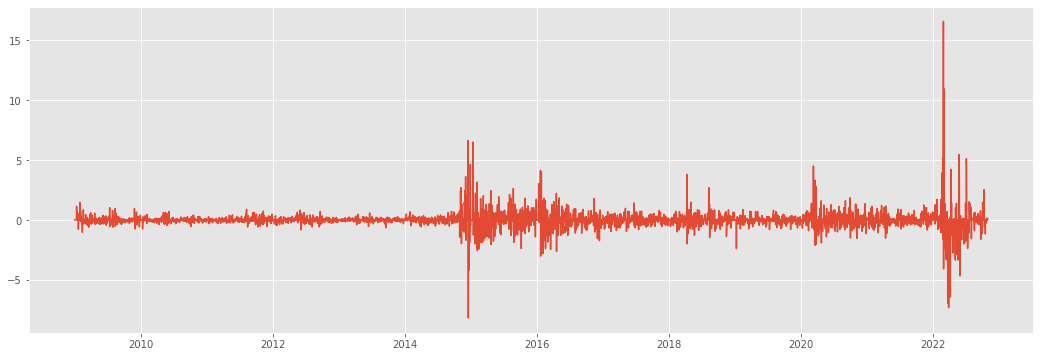

In [ ]:
plt.figure(figsize=(18,6))

plt.plot(prep_df.d_dollar.index, prep_df.d_dollar.values);

## **Визуальный анализ и выбор признаков**
---
Выделим из загруженной таблицы поля, которые будем использовать для анализа

Также выделим временные границы для последующей работы: возможно, нет смысла использовать динамику курса до 2014 года - она была совсем другой. Также мы можем убрать из обучающей выборки данные 2022 года, чтобы посмотреть как будет эмбеддить сеть резкие скачки (аномалии)


In [ ]:
# Устанавливаем границы выбора данных для обучающей и тестовой выборок

train_start = dt.datetime(year=2014, month=1, day=1)
train_end = dt.datetime(year=2022, month=1, day=1)
test_start = train_end
test_end = prep_df.index[-1]

train_cond = prep_df.index <= train_end
train_cond = train_cond & (prep_df.index >= train_start)
test_cond = prep_df.index >= test_start
test_cond = test_cond & (prep_df.index <= test_end)

len(prep_df), sum(train_cond), sum(test_cond)

(5052, 2923, 304)

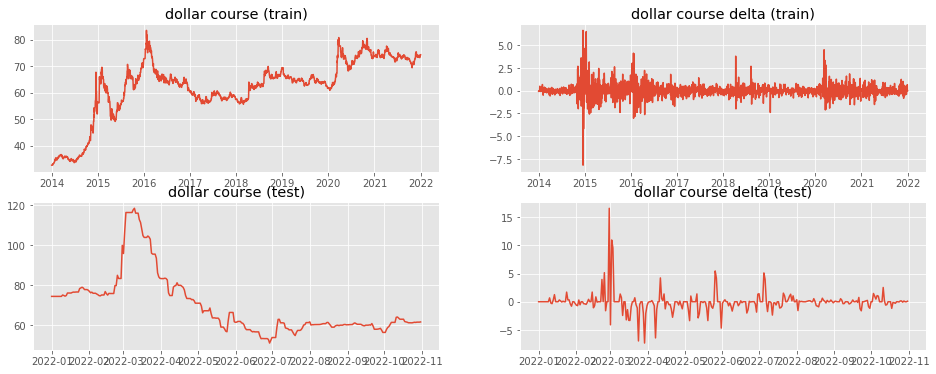

In [ ]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(221)
ax1.plot(prep_df.dollar.loc[train_cond])
ax1.set_title('dollar course (train)')
ax2 = plt.subplot(222)
ax2.plot(prep_df.d_dollar.loc[train_cond])
ax2.set_title('dollar course delta (train)')

ax3 = plt.subplot(223)
ax3.plot(prep_df.dollar.loc[test_cond])
ax3.set_title('dollar course (test)')
ax4 = plt.subplot(224)
ax4.plot(prep_df.d_dollar.loc[test_cond])
ax4.set_title('dollar course delta (test)')

plt.show()

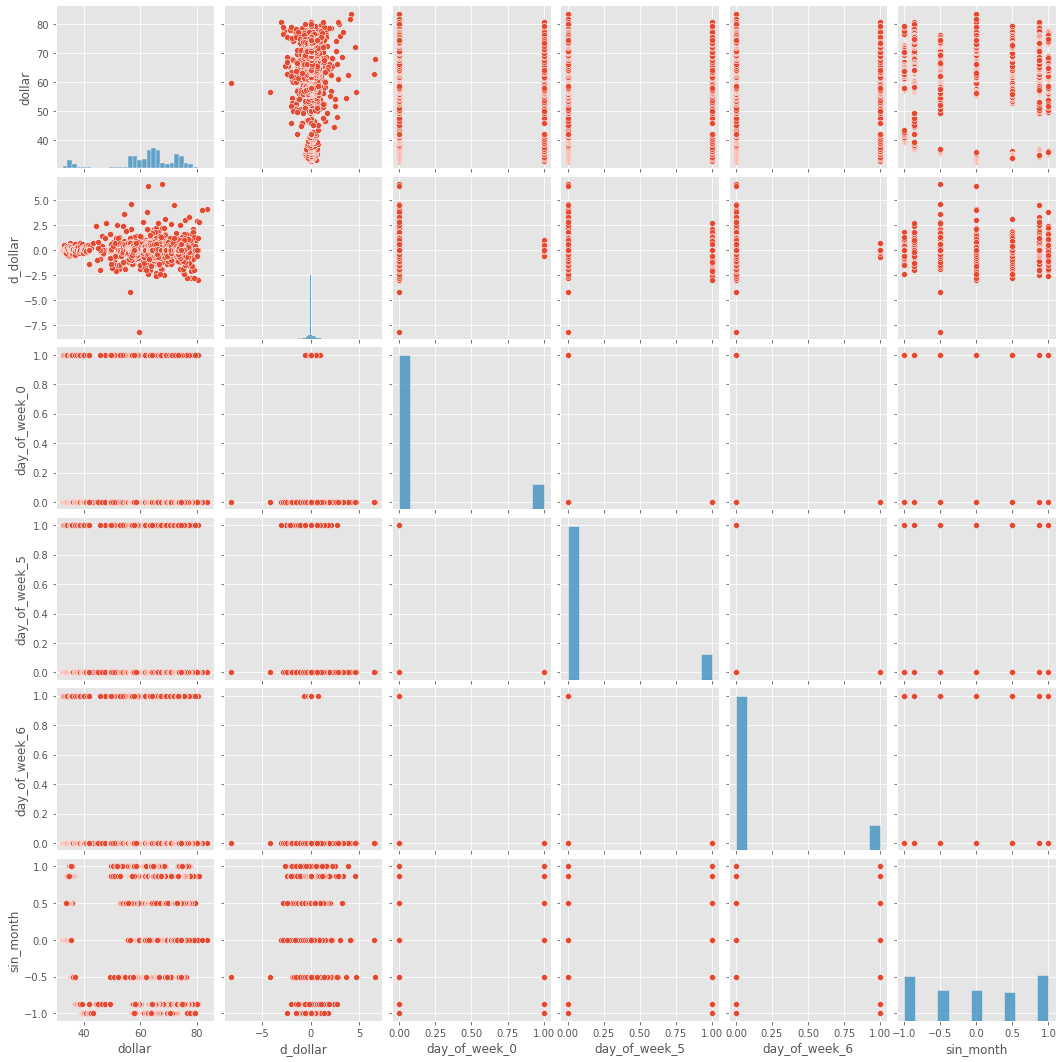

In [ ]:
features = ['dollar', 'd_dollar', 'day_of_week_0', 'day_of_week_5', 'day_of_week_6', 'sin_month']
sbn.pairplot(prep_df.loc[train_cond, features]);

In [ ]:
# уточняем признаки, с которыми далее будем работать
prep_df.columns
features = ['dollar', 'd_dollar', 'day_of_week_5', 'day_of_week_6', 'sin_month']
# уточняем целевые признаки, которые хотим кодировать/воспроизводить
goal_features = ['dollar', 'd_dollar']
goal_indexes = [features.index(x) for x in goal_features]
print(goal_indexes)

[0, 1]


resume:

- необходимо шкалировать чисто числовые признаки, так как они имеют разный разброс;
- есть статистическая зависимость между сезоном (месяцем) и диапазоном и средним изменений d_dollar;
- видим, что на изменение курса доллара влияет фактор выходного дня;

## **Готовим датасеты**
---
- Выбираем ширину окна win_width и шаг по окну win_step;
- формируем свой класс датасета;
- готовим datasets для обучения и для тестирования

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available(): 
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cpu')

### Фильтруем признаки и данные
---
- Выберем после результатов анализа зависимостей признаки, которые оказывают влияние на изменение основной величины (курса доллара); вектора с данными признаками будут подаваться на вход АЭ;

- также укажем конкретно какие признаки мы хотим эмбеддить/кодировать (остальные признаки будут вспомогательными для кодирования); эта информация будет использоваться для обучении АЭ при оценке лосса (будем требовать восстановления только данных целевых признаков);

- оформим все данные в виде отдельной таблицы df и тензора data; его далее мы и будем использовать как источника для формирования последовательностей векторов для обучения автоэнкодера;

In [ ]:
df = prep_df[features]
df.tail(3)

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
datetime,,,,,
2022-10-29,61.5294,0.0000,1,0,-1.0
2022-10-30,61.5294,0.0000,0,1,-1.0
2022-10-31,61.6277,0.0983,0,0,-1.0


### Масштабирование данных
---
- перед применение нейросети необходимо отмасштабировать данные. Это можно сделать сразу или строить pipline непосредственно при обучении/применении нейросети.

- шкалер нам может понадобиться для того, чтобы дешкалировать данные для последующего анализа.

In [ ]:
df.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,51.370161,0.006381,0.142914,0.142914,4.993958e-03
std,18.079718,0.650414,0.350019,0.350019,7.070891e-01
min,27.262500,-8.182200,0.000000,0.000000,-1.000000e+00
25%,31.568700,-0.094100,0.000000,0.000000,-5.000000e-01
50%,57.558500,0.000000,0.000000,0.000000,1.224647e-16
75%,65.666950,0.085050,0.000000,0.000000,8.660254e-01
max,118.438900,16.569800,1.000000,1.000000,1.000000e+00


Воспользуемся стандартным шкалером для масштабирования самого курса и его колебаний;

- нужно указать какие из признаков мы будем кодировать features_to_scale; в нашем случае набор признаков совпадает с целевыми признаками

- шкалирование производим по обучающей выборке

In [ ]:
from sklearn.preprocessing import StandardScaler

dollar_scaler = StandardScaler()
features_to_scale = goal_features
dollar_scaler.fit(df.loc[train_cond, features_to_scale])

df_norm = df.copy()
df_norm.loc[:, features_to_scale] = dollar_scaler.transform(df.loc[:, features_to_scale])
df_norm.describe()

,dollar,d_dollar,day_of_week_5,day_of_week_6,sin_month
count,5052.000000,5052.000000,5052.000000,5052.000000,5.052000e+03
mean,-0.978557,-0.013103,0.142914,0.142914,4.993958e-03
std,1.624655,1.082214,0.350019,0.350019,7.070891e-01
min,-3.144887,-13.637959,0.000000,0.000000,-1.000000e+00
25%,-2.757929,-0.180292,0.000000,0.000000,-5.000000e-01
50%,-0.422468,-0.023720,0.000000,0.000000,1.224647e-16
75%,0.306162,0.117793,0.000000,0.000000,8.660254e-01
max,5.048285,27.546520,1.000000,1.000000,1.000000e+00


In [ ]:
data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)
data.shape

<ipython-input-15-27c5b442a110>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(torch.from_numpy(df_norm.values), dtype=torch.float32, device=device)


torch.Size([5052, 5])

### Выбираем ширину окна win_width, формируем датасет последовательностей
---
данный класс можно будет использовать:
- для разделения на обучющий (до определенной даты) и тестовый (после определенной даты); 
- для оценки точности алгоритма кодирования на всей выборке;

In [ ]:
class TS_Dataset(Dataset):
    """ Формирование датасета с оконными последовательностями показателей
    data - torch-массив значений показателей с изменением времени, 
    data[idx] - набор показателей в момент времени t[idx]
    win_width - ширина окна, здесь - кол-во временных точек измерения
    transform - преобразование, которое необходимо применить к формируемой последовательности данных
    ВЫХОД:
    - для данного idx окно трансформированных показателей - torch массив размером (win_width, *data.shape)
      динамика показателей с момента t[idx] до t[idx + win_width]
    """
    def __init__(self, data:torch.Tensor, win_width:int, transform=None):
        super(TS_Dataset).__init__()
        self.win_width = win_width
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.win_width + 1

    def __getitem__(self, idx):
        idx = idx % len(self)
        data_seq = self.data[idx : idx + self.win_width]

        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

In [ ]:
# ширина окна
win_width = 31

all_dataset = TS_Dataset(data, win_width=win_width)
print(len(all_dataset))

5022


### Формируем выборки для обучения и тестирования и соответствующие даталоадеры
---
Применяем два этапа разбиения.
- Этап 1. Выбираем дату, разделяющую всю последовательность на две части - обучающую и тестовую; это полезно для обучения прогнозированию и выявления аномалий.

- Этап 2. Из всех последовательностей выбираем случайно определенный % для обучающей выборки; остальные - в выборку для валидизации. 

Реализуем класс WindowDataset, в который можно передать не только ширину окна, но и метки времени, с которых начинать выбирать последовательности векторов из переданного массива data.

In [ ]:
class WindowDataset(Dataset):
    def __init__(self, data: torch.Tensor, win_width: int, starts: tuple, active_dim: int = 0, transform=None):
        self.win_width = win_width
        self.data = data
        self.transform = transform
        self.dim: int = active_dim
        self.starts = starts
        assert len(starts) <= self.data.size()[self.dim], "кол-во стартовых точек должно быть менььше кол-ва наблюдений N"
        assert 0 <= max(starts) <= self.data.size()[self.dim] - win_width, "индексы стартовых точек должны лежать в интервале [0, N-width]"

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx) -> torch.Tensor:
        data_seq = self.data.index_select(dim=self.dim, index=torch.LongTensor([i for i in range(self.starts[idx], self.starts[idx] + self.win_width)]))
        if self.transform:
            data_seq = self.transform(data_seq)
        return data_seq, data_seq

Сгенерируем метки времени для обучающей и тестовой выборки - как случайно выбранные значения из набора 0, step, 2*step, ...

In [ ]:
def get_window_time_starts(data_len, win_width, win_step=1, prct=0.7):
    """ выбирает стартовые индексы с учетом шага случайно, если  prct < 1.0
    args
    - data_len - общее количество индексов (моментов времени наблюдений);
    - win_width - ширина окна;
    - win_step - шаг, с которым будем брать стартовые индексы;
    - prct - доля отбираемых индексов для основной выборки из всех возможных;
    """
    assert 0 < prct <= 1.0, "доля индексов должна быть 0 < prct <= 1"
    all_indexes = list(range(0, data_len - win_width + 1, win_step))
    if prct < 1.0:
        N = (data_len - win_width) // win_step + 1
        main_indexes = np.random.choice(all_indexes, size=round(prct * N), replace=False)
    else:
        main_indexes = all_indexes

    rest_indexes = list(set(all_indexes).difference(set(main_indexes)))
    
    return main_indexes, rest_indexes

Создадим соответствующие датасеты

In [ ]:
# шаги, с которым будем формировать данные выборки
win_step_1 = 1
win_step_2 = 2

train_indexes, valid_indexes = get_window_time_starts(len(data[train_cond]), win_width, win_step=win_step_2, prct=0.75)
test_indexes, _ = get_window_time_starts(len(data[test_cond]), win_width, win_step=win_step_1, prct=1.0)
len(train_indexes), len(valid_indexes), len(test_indexes)

(1085, 362, 274)

In [ ]:
train_dataset = WindowDataset(data[train_cond], starts=train_indexes, win_width=win_width)
valid_dataset = WindowDataset(data[train_cond], starts=valid_indexes, win_width=win_width)
test_dataset = WindowDataset(data[test_cond], starts=test_indexes, win_width=win_width)
len(train_dataset), len(valid_dataset), len(test_dataset)

(1085, 362, 274)

## **Формируем даталоадеры**
---
- выбираем batch_size
- формируем даталоадеры для обучения 
- программируем обертку для даталоадера, который готовит батч
# - формируем тензор/батч для тестирования

In [ ]:
# выбираем размер пакета для обучения
batch_size = 32

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size())
# batch_seq[0]

torch.Size([32, 31, 5])


- чтобы не было проблем с загрузкой данных на девайс, лучше использовать обвертку для даталоадеров WrappedDataLoader

- При подготовке пакета для обучения/тестирования из даталоадера с текущим датасетом будет выдаваться тензор вида (batch_size, seq_len, features);
- для nn.LSTM обычно меняют местами индексы batch_size, seq_len, т.е. должен на вход поступать тензор вида (seq_len, batch_size, features); мы можем это сделать также в функции preprocess. Но мы можем использовать опцию batch_first=True в LSTM, чтобы не менять индексы.

In [ ]:
def preprocess(x, y):
    # x = torch.permute(x, (1, 0, 2))
    # y = torch.permute(y, (1, 0, 2))
    return x.to(device), y.to(device)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [ ]:
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size())

torch.Size([32, 31, 5])


## **Строим АЭ с выделением энкодера в отдельную нейросеть**
---
Создадим RNN - автоэнкодер с ячейкой LSTM который выделяет важные признаки в последовательностях заданной длины заданных векторов фичей.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [ ]:
# выбираем размерность скрытого вектора состояния LSTM
hidden_size = latent_dim = 20

In [ ]:
"""
для nn.LSTM на вход должен поступать тензор вида (batch_size, seq_len, features)
"""
class Encoder_sequence(nn.Module):
    def __init__(self, n_features: int, hidden_size: int = 16, n_layers=2):
        super(Encoder_sequence,self).__init__()
        self.input_size = n_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.LSTM1 = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=n_layers, dropout=0.2, batch_first=True)
        
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros_like(h0)
        out, (hn, cn) = self.LSTM1(x, (h0, c0))
        return out, hn


encoder = Encoder_sequence(n_features=len(features), hidden_size=hidden_size).to(device)
batch_seq, _ = next(iter(valid_dl))
print(batch_seq.size(), batch_seq[0,0,0].dtype)
encoder

torch.Size([32, 31, 5]) torch.float32


Encoder_sequence(
  (LSTM1): LSTM(5, 20, num_layers=2, batch_first=True, dropout=0.2)
)

In [ ]:
out, hn = encoder(batch_seq)
batch_seq.size(), out.size(), hn.size()

(torch.Size([32, 31, 5]), torch.Size([32, 31, 20]), torch.Size([2, 32, 20]))

In [ ]:
class Decoder_to_sequence(nn.Module):
    """  
    ВХОД: 
    - подается батч кодов последовательностей - тензор размерностью (n_layers, batch_size, latent_dim)
    ВЫХОД:
    - батч последовательностей фичей - тензор размерностью (batch_size, seq_len, features)
    """
    def __init__(self, n_features: int, seq_len: int, hidden_size: int = 16, n_layers=2):
        super(Decoder_to_sequence,self).__init__()
        self.input_size = n_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.LSTM1 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=n_layers, dropout=0.2, batch_first=True)
        self.linear = nn.Linear(hidden_size, n_features)
        
    def forward(self, x, h0):
        c0 = torch.zeros_like(h0)
        out, (hn, cn) = self.LSTM1(x, (h0, c0))
        out = torch.permute(out, (1, 0, 2))
        outputs = []
        for elem in out:
            output = self.linear(elem.squeeze())
            outputs.append(output.unsqueeze(0))
        outputs = torch.cat(outputs, dim=0)
        outputs = torch.permute(outputs, (1, 0, 2))
        return outputs

decoder = Decoder_to_sequence(n_features=len(features), hidden_size=hidden_size, seq_len=win_width)
decoder

Decoder_to_sequence(
  (LSTM1): LSTM(20, 20, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=20, out_features=5, bias=True)
)

In [ ]:
decode = decoder(out, hn)
out.size(), hn.size(), decode.size()

(torch.Size([32, 31, 20]), torch.Size([2, 32, 20]), torch.Size([32, 31, 5]))

In [ ]:
class RNN_ae(nn.Module):
    def __init__(self, encoder, decoder):
        super(RNN_ae, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        out, hn = encoder(x)
        y = self.decoder(out, hn)
        return y

rnn_ae = RNN_ae(encoder, decoder)
rnn_ae

RNN_ae(
  (encoder): Encoder_sequence(
    (LSTM1): LSTM(5, 20, num_layers=2, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder_to_sequence(
    (LSTM1): LSTM(20, 20, num_layers=2, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=20, out_features=5, bias=True)
  )
)

In [ ]:
reconstucted_seq = rnn_ae(batch_seq)
reconstucted_seq.size(), batch_seq.size()

(torch.Size([32, 31, 5]), torch.Size([32, 31, 5]))

## **Обучаем АЭ**
---

In [ ]:
def loss_func(y_pred, y_true):
    return F.mse_loss(y_pred[:, :, goal_indexes], y_true[:, :, goal_indexes])

loss_func(batch_seq, reconstucted_seq)

tensor(0.8915, grad_fn=<MseLossBackward0>)

In [ ]:
# Функция обучения нейросети

def train_ae_model(model, train_loader, test_loader, epochs=5, print_step = 1, verbose=False):
    errs = []
    for epoch in range(epochs):
        for xb, yb in train_loader:
            pred = model(xb)
            # print(pred.shape, xb.shape)
            loss = loss_func(pred, xb)

            ## --- обратный проход, вычисление градиентов ---
            optimizer.zero_grad() # чтобы не накапливались градиенты
            loss.backward()

            ## --- корректировка весов ---
            optimizer.step()

        if (epoch % print_step == 0) or (epoch == epochs - 1):
            with torch.no_grad():
                errs1 = []
                for xb, yb in test_loader:
                    testloss = loss_func(model(xb), yb).cpu().item()
                    errs1.append(testloss)
                meanloss = sum(errs1) / len(errs1)
                errs.append(meanloss)
            if verbose:
                print('epoch=', epoch, '; loss=', meanloss)

    return errs

err_list = []

In [ ]:
# Создадим оптимизатор
from torch.optim import Adam, RMSprop

optimizer = Adam(rnn_ae.parameters(), lr=0.0002)
# optimizer = RMSprop(cnn_ae.parameters(), lr=0.0002)

In [ ]:
print_step = 10
errs = train_ae_model(rnn_ae, train_dl, valid_dl, epochs=250, print_step=print_step, verbose=True)
err_list += errs

epoch= 0 ; loss= 1.0001465777556102
epoch= 10 ; loss= 0.625770720342795
epoch= 20 ; loss= 0.6668823584914207
epoch= 30 ; loss= 0.5789644743005434
epoch= 40 ; loss= 0.5699925385415554
epoch= 50 ; loss= 0.5693622703353564
epoch= 60 ; loss= 0.3120778848727544
epoch= 70 ; loss= 0.2173694825420777
epoch= 80 ; loss= 0.14523997157812119
epoch= 90 ; loss= 0.13869082368910313
epoch= 100 ; loss= 0.10735960180560748
epoch= 110 ; loss= 0.09543144625301163
epoch= 120 ; loss= 0.0856023586044709
epoch= 130 ; loss= 0.08000570473571618
epoch= 140 ; loss= 0.07612709507035713
epoch= 150 ; loss= 0.07184824836440384
epoch= 160 ; loss= 0.06311889140245815
epoch= 170 ; loss= 0.06124452811976274
epoch= 180 ; loss= 0.057981250419591866
epoch= 190 ; loss= 0.0627679309497277
epoch= 200 ; loss= 0.06190609644788007
epoch= 210 ; loss= 0.05318123800680041
epoch= 220 ; loss= 0.047318336088210344
epoch= 230 ; loss= 0.052371085000534855
epoch= 240 ; loss= 0.04912342488144835
epoch= 249 ; loss= 0.04199321746515731


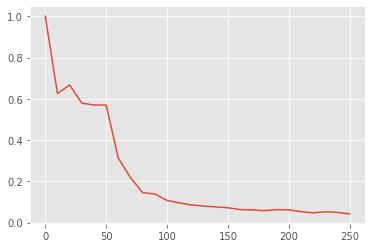

In [ ]:
plt.plot(range(0, len(err_list) * print_step, print_step), err_list);

## **Кластеризуем окна (k-means, agglomerative, ward, DBSCAN, ...)**
---

**Кодируем энкодером последовательности**

In [ ]:
codes = []
with torch.no_grad():
    for idx in range(len(all_dataset)):
        x, _ = all_dataset[idx]
        #x = x.transpose(1, 0)
        x = x.unsqueeze(0)
        # print(x.size(), end='; --> ')
        out, code = encoder(x)
        # print(code.size())
        codes.append(code.detach().numpy().reshape(1, -1))

all_codes = np.concatenate(codes, axis=0)
all_codes.shape

(5022, 40)

## **Делаем проекцию tSNE и визуализируем структуру кодов**
---

In [ ]:
from sklearn.manifold import TSNE

X = all_codes
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(5022, 2)

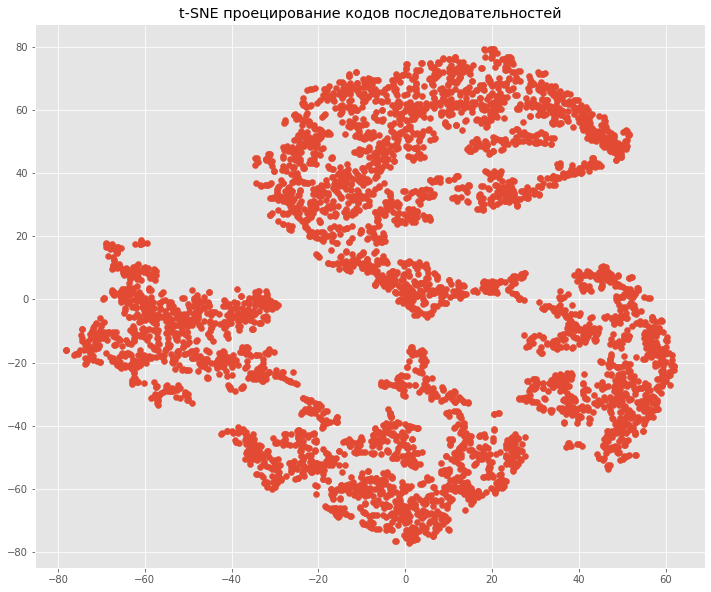

In [ ]:
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE проецирование кодов последовательностей');

## Выполним кластеризацию и проанализируем получившуюся структуру кластеров
---

### Метод kmeans++.
---
Определим оптимальное кол-во кластеров

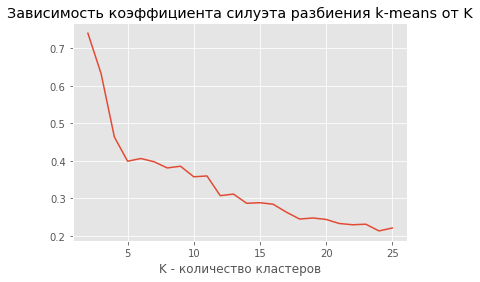

In [ ]:
# Применение k-means
from sklearn.cluster import KMeans
from sklearn import metrics

X = all_codes
k_start = 2
k_end = 25

crit2 = []
for k in range(k_start, k_end + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    crit2.append(metrics.silhouette_score(X, kmeans.labels_))

plt.plot(range(k_start, k_end + 1), crit2)
plt.xlabel('K - количество кластеров')
plt.title('Зависимость коэффициента силуэта разбиения k-means от K');

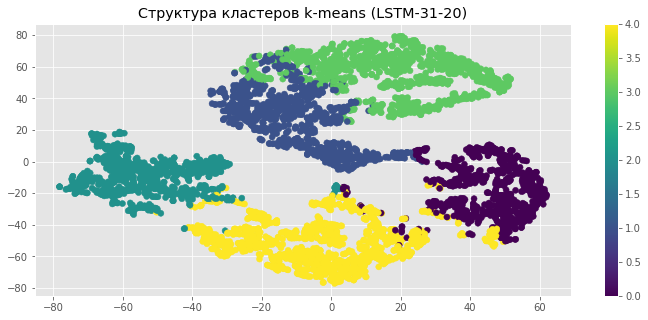

In [ ]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=123)

# применяем - обучаем
kmeans.fit(X)
# метки кластеров
labels = kmeans.labels_
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.colorbar()
plt.title('Структура кластеров k-means (LSTM-31-20)')
plt.show()

In [ ]:
pd.Series(labels).value_counts()

4    1223
3    1131
1     980
2     849
0     839
dtype: int64

Проанализируем примеры последовательностей из разных кластеров

In [ ]:
centers_code = torch.tensor(torch.from_numpy(kmeans.cluster_centers_), dtype=torch.float32, device=device)
centers_code = centers_code.view(centers_code.shape[0], 2, -1)
centers_code = torch.permute(centers_code, (1, 0, 2))
centers_code.shape

<ipython-input-95-4ce82a94d568>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(kmeans.cluster_centers_), dtype=torch.float32, device=device)


torch.Size([2, 5, 20])

In [ ]:
# так как у нас нет выхода энкодера, то продублируем выход с последнего слоя хиддена
outputs = []
for index in range(win_width):
    output = centers_code[-1, :, :]
    outputs.append(output.unsqueeze(0))
outputs = torch.cat(outputs, dim=0)
outputs = torch.permute(outputs, (1, 0, 2))

centers_seq = decoder(outputs, centers_code)
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape, outputs.shape

torch.Size([5, 31, 20])

(torch.Size([2, 5, 20]), torch.Size([5, 31, 5]), (5, 31, 5))

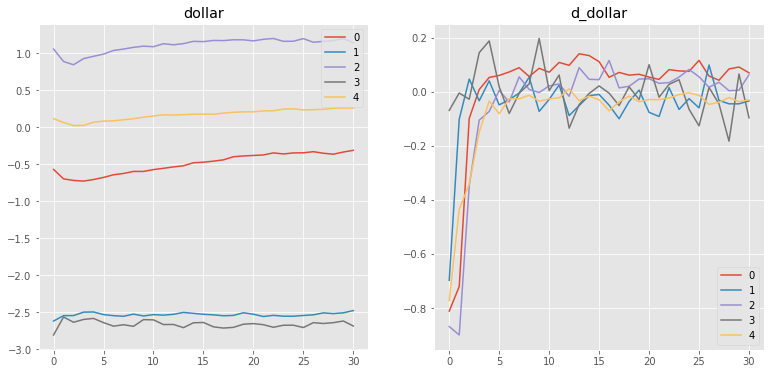

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

In [ ]:
pd.Series(labels).value_counts()

4    1223
3    1131
1     980
2     849
0     839
dtype: int64

### Метод DBSCAN
---

Этот метод интересен тем, что он может помочь выявить аномалии

In [ ]:
from sklearn.cluster import DBSCAN

X = all_codes

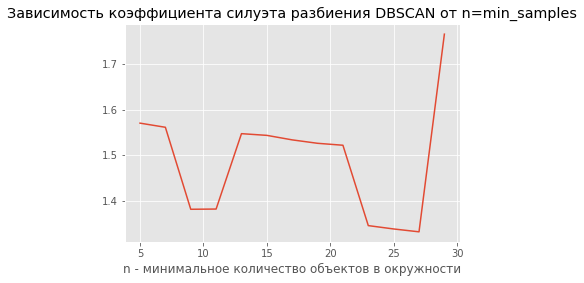

In [ ]:
# применим силуэтный анализ
n_start = 5
n_end = 30
n_step = 2

crit3 = []
for n in range(n_start, n_end + 1, n_step):
    dbscan = DBSCAN(eps=0.15, min_samples=n, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    crit3.append(metrics.silhouette_score(X1, labels_1) * len(np.unique(labels_1)) * len(X1) / len(X))

plt.plot(range(n_start, n_end + 1, n_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от n=min_samples');

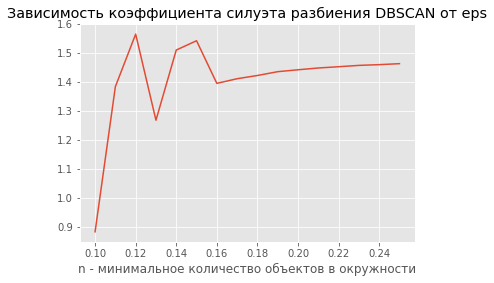

In [ ]:
# применим силуэтный анализ
eps_start = 0.1
eps_end = 0.25
eps_step = 0.01

crit3 = []
for eps in np.arange(eps_start, eps_end + eps_step, eps_step):
    dbscan = DBSCAN(eps=eps, min_samples=15, metric='euclidean',  algorithm='auto')
    dbscan.fit(X)
    X1 = X[dbscan.labels_ != -1]
    labels_1 = dbscan.labels_[dbscan.labels_ != -1]
    #print(eps)
    crit3.append(metrics.silhouette_score(X1, labels_1) * len(np.unique(labels_1)) * len(X1) / len(X))

plt.plot(np.arange(eps_start, eps_end + eps_step, eps_step), crit3)
plt.xlabel('n - минимальное количество объектов в окружности')
plt.title('Зависимость коэффициента силуэта разбиения DBSCAN от eps');

выберем значения параметров

In [ ]:
dbscan = DBSCAN(eps=0.15, min_samples=35, metric='euclidean',  algorithm='auto')
dbscan.fit(X)
labels_1 = dbscan.labels_
pd.Series(labels_1).value_counts()

 0    1881
 1    1672
-1     871
 2     598
dtype: int64

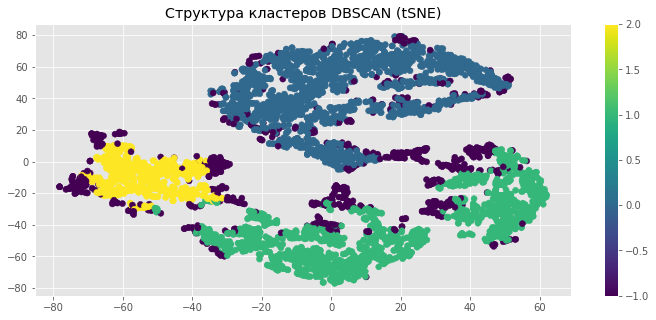

In [ ]:
# визуализируем получившееся разбиение с учетом знания цифр на картинках
# и сравним с разбиением на кластеры, полученным с помощью k-means
plt.figure(figsize=(12,5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_1)
plt.colorbar()
plt.title('Структура кластеров DBSCAN (tSNE)')
plt.show()

проанализируем примеры последовательностей из разных кластеров

In [ ]:
labels_1 = dbscan.labels_[dbscan.labels_ != -1]
cluster_centers = np.array([X[dbscan.labels_ == label].mean(axis=0) for label in range(max(dbscan.labels_)+1)])
centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)
centers_code = centers_code.view(centers_code.shape[0], 2, -1)
centers_code = torch.permute(centers_code, (1, 0, 2))
centers_code.shape

<ipython-input-160-686a752b7386>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers_code = torch.tensor(torch.from_numpy(cluster_centers), dtype=torch.float32, device=device)


torch.Size([2, 3, 20])

In [ ]:
# так как у нас нет выхода энкодера, то продублируем выход с последнего слоя хиддена
outputs = []
for index in range(win_width):
    output = centers_code[-1, :, :]
    outputs.append(output.unsqueeze(0))
outputs = torch.cat(outputs, dim=0)
outputs = torch.permute(outputs, (1, 0, 2))

centers_seq = decoder(outputs, centers_code)
np_centers_seq = centers_seq.detach().numpy()
centers_code.shape, centers_seq.shape, np_centers_seq.shape, outputs.shape

(torch.Size([2, 3, 20]),
 torch.Size([3, 31, 5]),
 (3, 31, 5),
 torch.Size([3, 31, 20]))

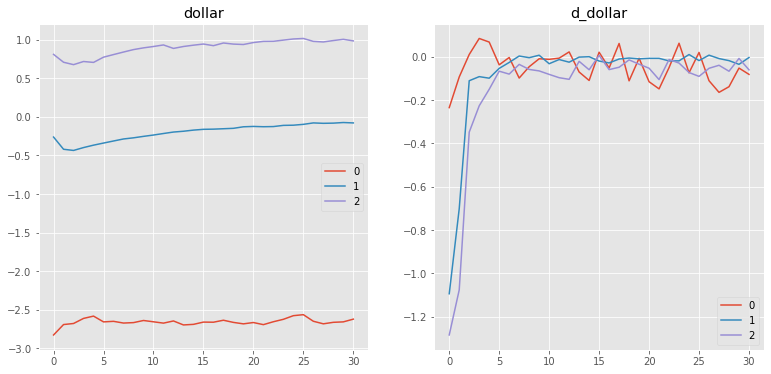

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))

# визуализируем получившиеся последовательности
for index in goal_indexes:
    ax[index].set_title(df.columns[index])
    for label in np.unique(labels_1):
        ax[index].plot(range(win_width), np_centers_seq[label, :, index].ravel(), label=str(label))
        ax[index].legend()

fig.show()

## **Сохранение обученной модели**
------

In [ ]:
model_name = 'lstm_ae-seq' + str(win_width) + '-ls' + str(latent_dim)
print(model_name)
torch.save(rnn_ae.state_dict(), path + 'models/' + model_name)

conv_ae-seq31-ls20_k5-3-2
